<a href="https://colab.research.google.com/github/dadang6842/AI-study/blob/main/assignments/HAR_LSTM_Attention_250804.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- https://github.com/Uchan99/HumanActivityReconition/blob/main/WISDM/250118_WISDM(dynamic)_992.ipynb
- 위 블로그 참고

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, Sequential
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import keras.models
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [3]:
data = pd.read_csv("/content/drive/MyDrive/AI_data/WIDSM.csv", index_col=0)
data

,user_id,activity,timestamp,x_axis,y_axis,z_axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164
...,...,...,...,...,...,...
1098199,19,Sitting,131623331483000,9.000000,-1.570000,1.690000
1098200,19,Sitting,131623371431000,9.040000,-1.460000,1.730000
1098201,19,Sitting,131623411592000,9.080000,-1.380000,1.690000
1098202,19,Sitting,131623491487000,9.000000,-1.460000,1.730000


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1098203 entries, 0 to 1098203
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user_id    1098203 non-null  int64  
 1   activity   1098203 non-null  object 
 2   timestamp  1098203 non-null  int64  
 3   x_axis     1098203 non-null  float64
 4   y_axis     1098203 non-null  float64
 5   z_axis     1098203 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 58.7+ MB


In [5]:
data['x_axis'] = data['x_axis'].astype('float32')
data['y_axis'] = data['y_axis'].astype('float32')
data['z_axis'] = data['z_axis'].astype('float32')

In [6]:
df = data.drop(['user_id', 'timestamp'], axis = 1).copy()
df.head()

,activity,x_axis,y_axis,z_axis
0,Jogging,-0.694638,12.680544,0.503953
1,Jogging,5.012288,11.264028,0.953424
2,Jogging,4.903325,10.882658,-0.081722
3,Jogging,-0.612916,18.496431,3.023717
4,Jogging,-1.184970,12.108489,7.205164


<Axes: xlabel='activity', ylabel='count'>

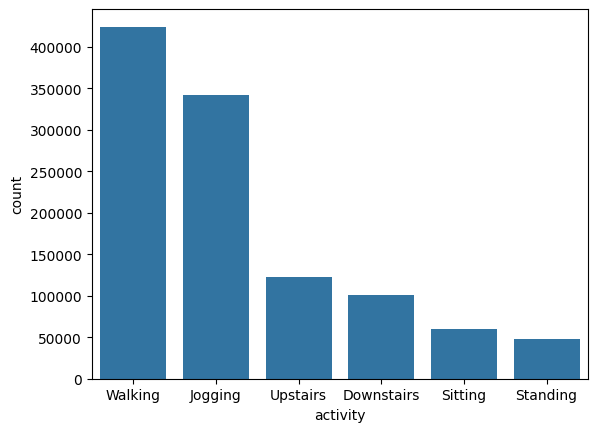

In [7]:
sns.countplot(x='activity', data=df, order=df.activity.value_counts().index)

In [8]:
df['activity'].value_counts()

,count
activity,
Walking,424397
Jogging,342176
Upstairs,122869
Downstairs,100427
Sitting,59939
Standing,48395


In [9]:
# 4개의 레이블을 dataframe으로 만듦
Walking = df[df['activity']=='Walking'].head(100427).copy()
Jogging = df[df['activity']=='Jogging'].head(100427).copy()
Upstairs = df[df['activity']=='Upstairs'].head(100427).copy()
Downstairs = df[df['activity']=='Downstairs'].head(100427).copy()

In [10]:
# 4개의 dataframe을 이어 붙임
dynamic_df = pd.DataFrame()
dynamic_df = pd.concat([Walking, Jogging, Upstairs, Downstairs])
dynamic_df.shape

(401708, 4)

In [11]:
dynamic_df['activity'].value_counts()

,count
activity,
Walking,100427
Jogging,100427
Upstairs,100427
Downstairs,100427


In [12]:
label = LabelEncoder()
dynamic_df['label'] = label.fit_transform(dynamic_df['activity'])
dynamic_df.head()

,activity,x_axis,y_axis,z_axis,label
597,Walking,0.844462,8.008764,2.792171,3
598,Walking,1.116868,8.621680,3.786457,3
599,Walking,-0.503953,16.657684,1.307553,3
600,Walking,4.794363,10.760075,-1.184970,3
601,Walking,-0.040861,9.234595,-0.694638,3


In [13]:
X = dynamic_df[['x_axis', 'y_axis', 'z_axis']]
y = dynamic_df['label']

In [14]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

scaled_X = pd.DataFrame(data = X, columns = ['X', 'Y', 'Z'])
scaled_X['label'] = y.values

scaled_X

,X,Y,Z,label
0,-0.063867,-0.000509,0.566252,3
1,-0.020199,0.098689,0.797759,3
2,-0.280024,1.399284,0.220577,3
3,0.569320,0.444780,-0.359777,3
4,-0.205788,0.197887,-0.245609,3
...,...,...,...,...
401703,-0.862898,-0.013256,0.556433,0
401704,-1.322972,0.229513,0.128011,0
401705,-1.617932,1.022558,-0.014020,0
401706,-1.415949,0.048245,-0.726503,0


stats.mode()
- HAR 분류: label에서 최빈값을 추출
- e.g. ModeResult(mode=np.int64(2), count=np.int64(128))을 반환
- mode: 최빈값
- count: 최빈값의 등장 횟수
- stats.mode(labels)[0]: ModeResult 객체의 mode값(=최빈값)을 가져옴

In [15]:
from scipy import stats

def create_dataset(X, y, time_steps=1, step=1):
  Xs, ys = [], []
  for i in range(0, len(X) - time_steps, step):
    v = X.iloc[i:i + time_steps].values
    labels = y.iloc[i: i + time_steps]
    Xs.append(v)
    ys.append(stats.mode(labels)[0])
  return np.array(Xs), np.array(ys).reshape(-1, 1)  # -1: 자동

TIME_STEPS = 128
STEP = 40

X_data, y_data = create_dataset(scaled_X[['X', 'Y', 'Z']], scaled_X.label, TIME_STEPS, STEP)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, stratify = y_data)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, stratify = y_train)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(6425, 128, 3) (6425, 1)
(2008, 128, 3) (2008, 1)


#### OneHotEncoder
handle_unknown
- "ignore": 학습 시점에 보지 못했던 새로운 범주가 등장하면 무시
- "error"(기본값): 에러 발생

sparse_output
- True: 희소 행렬 반환
- False: ndarray 출력

In [16]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown = "ignore", sparse_output = False)
enc = enc.fit(y_train)

y_train_one_hot = enc.transform(y_train)
y_test_one_hot = enc.transform(y_test) # y_train을 훈련한 걸 기준으로 데이터 변형
y_val_one_hot = enc.transform(y_val)

print(X_train.shape, y_train_one_hot.shape, X_test.shape, y_test_one_hot.shape)

(6425, 128, 3) (6425, 4) (2008, 128, 3) (2008, 4)


In [17]:
unique, counts = np.unique(y_train, return_counts=True) # 라벨과 개수 출
print ("Train data label statistics::")
print (np.asarray((unique, counts)).T) # .T: 전치

unique, counts = np.unique(y_test, return_counts=True)
print ("Test data label statistics::")
print (np.asarray((unique, counts)).T)

Train data label statistics::
[[   0 1606]
 [   1 1606]
 [   2 1607]
 [   3 1606]]
Test data label statistics::
[[  0 502]
 [  1 502]
 [  2 502]
 [  3 502]]


## Attention
### attention_3d_block
- feature 차원별 attention(input_dim)
- "무슨 특성(변수)이 중요한가?"를 판단
- 각 시점의 feature들에 각각 weight를 곱함

### attention_3d_block2
- 시간 차원별 attention(time_steps)
- "언제 발생한 정보가 중요한가?"를 판단
- 각 시점별 weight를 모든 feature에 동일하게 적용

### 공통점
- context vector로 요약하지 않음 -> 시점 별로 attention weight와 입력을 곱함

### SINGLE_ATTENTION_VECTOR
- True일 경우 모든 timestep에 대해 동일한 attention weight를 적용


In [18]:
def attention_3d_block(inputs, single_attention_vector=False):
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    a = inputs
    a_probs = Dense(input_dim, activation='softmax')(a)
    if single_attention_vector: # 모든 timestep에 대해 동일한 attention weight를 적용
        a_probs = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a_probs) # feature 차원 평균을 냄
        a_probs = RepeatVector(input_dim)(a_probs) # 다시 (batch_size, input_dim, time_steps) 형태로 복원
    output_attention_mul = Multiply()([inputs, a_probs]) # 입력과 attention을 곱함
    return output_attention_mul

def attention_3d_block2(inputs, single_attention_vector=False):
    # inputs.shape = (batch_size, time_steps, input_dim)
    time_steps = K.int_shape(inputs)[1]
    input_dim = K.int_shape(inputs)[2]
    a = Permute((2, 1))(inputs)
    a = Dense(time_steps, activation='softmax')(a) # time_steps 크기로 attention weight 생성
    if single_attention_vector:
        a = Lambda(lambda x: K.mean(x, axis=1))(a)
        a = RepeatVector(input_dim)(a)

    a_probs = Permute((2, 1))(a)
    output_attention_mul = Multiply()([inputs, a_probs])
    return output_attention_mul

In [19]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_one_hot.shape[1]
n_timesteps, n_features, n_outputs

(128, 3, 4)

In [20]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dropout, Flatten, Dense
from tensorflow.keras.layers import Multiply

inputs = Input(shape=(n_timesteps, n_features))

lstm_out = LSTM(128, return_sequences=True)(inputs)
lstm_out = LSTM(128, return_sequences=True)(lstm_out)
lstm_out = LSTM(128, return_sequences=True)(lstm_out)
lstm_out = Dropout(0.3)(lstm_out)
attention_mul = attention_3d_block(lstm_out)
attention_mul = Flatten()(attention_mul)

# dense layer
dense = Dense(64, activation='relu')(attention_mul)
outputs = Dense(4, activation='softmax')(dense)
model = Model(inputs, outputs)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 3)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 128, 128)  │     67,584 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 128, 128)  │    131,584 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 128, 128)  │    131,584 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128)  │          0 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128, 128)  │     16,512 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 128, 128)  │          0 │ dropout[0][0],    │
│                     │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 16384)     │          0 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │  1,048,640 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 4)         │        260 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,396,164 (5.33 MB)

 Trainable params: 1,396,164 (5.33 MB)

 Non-trainable params: 0 (0.00 B)

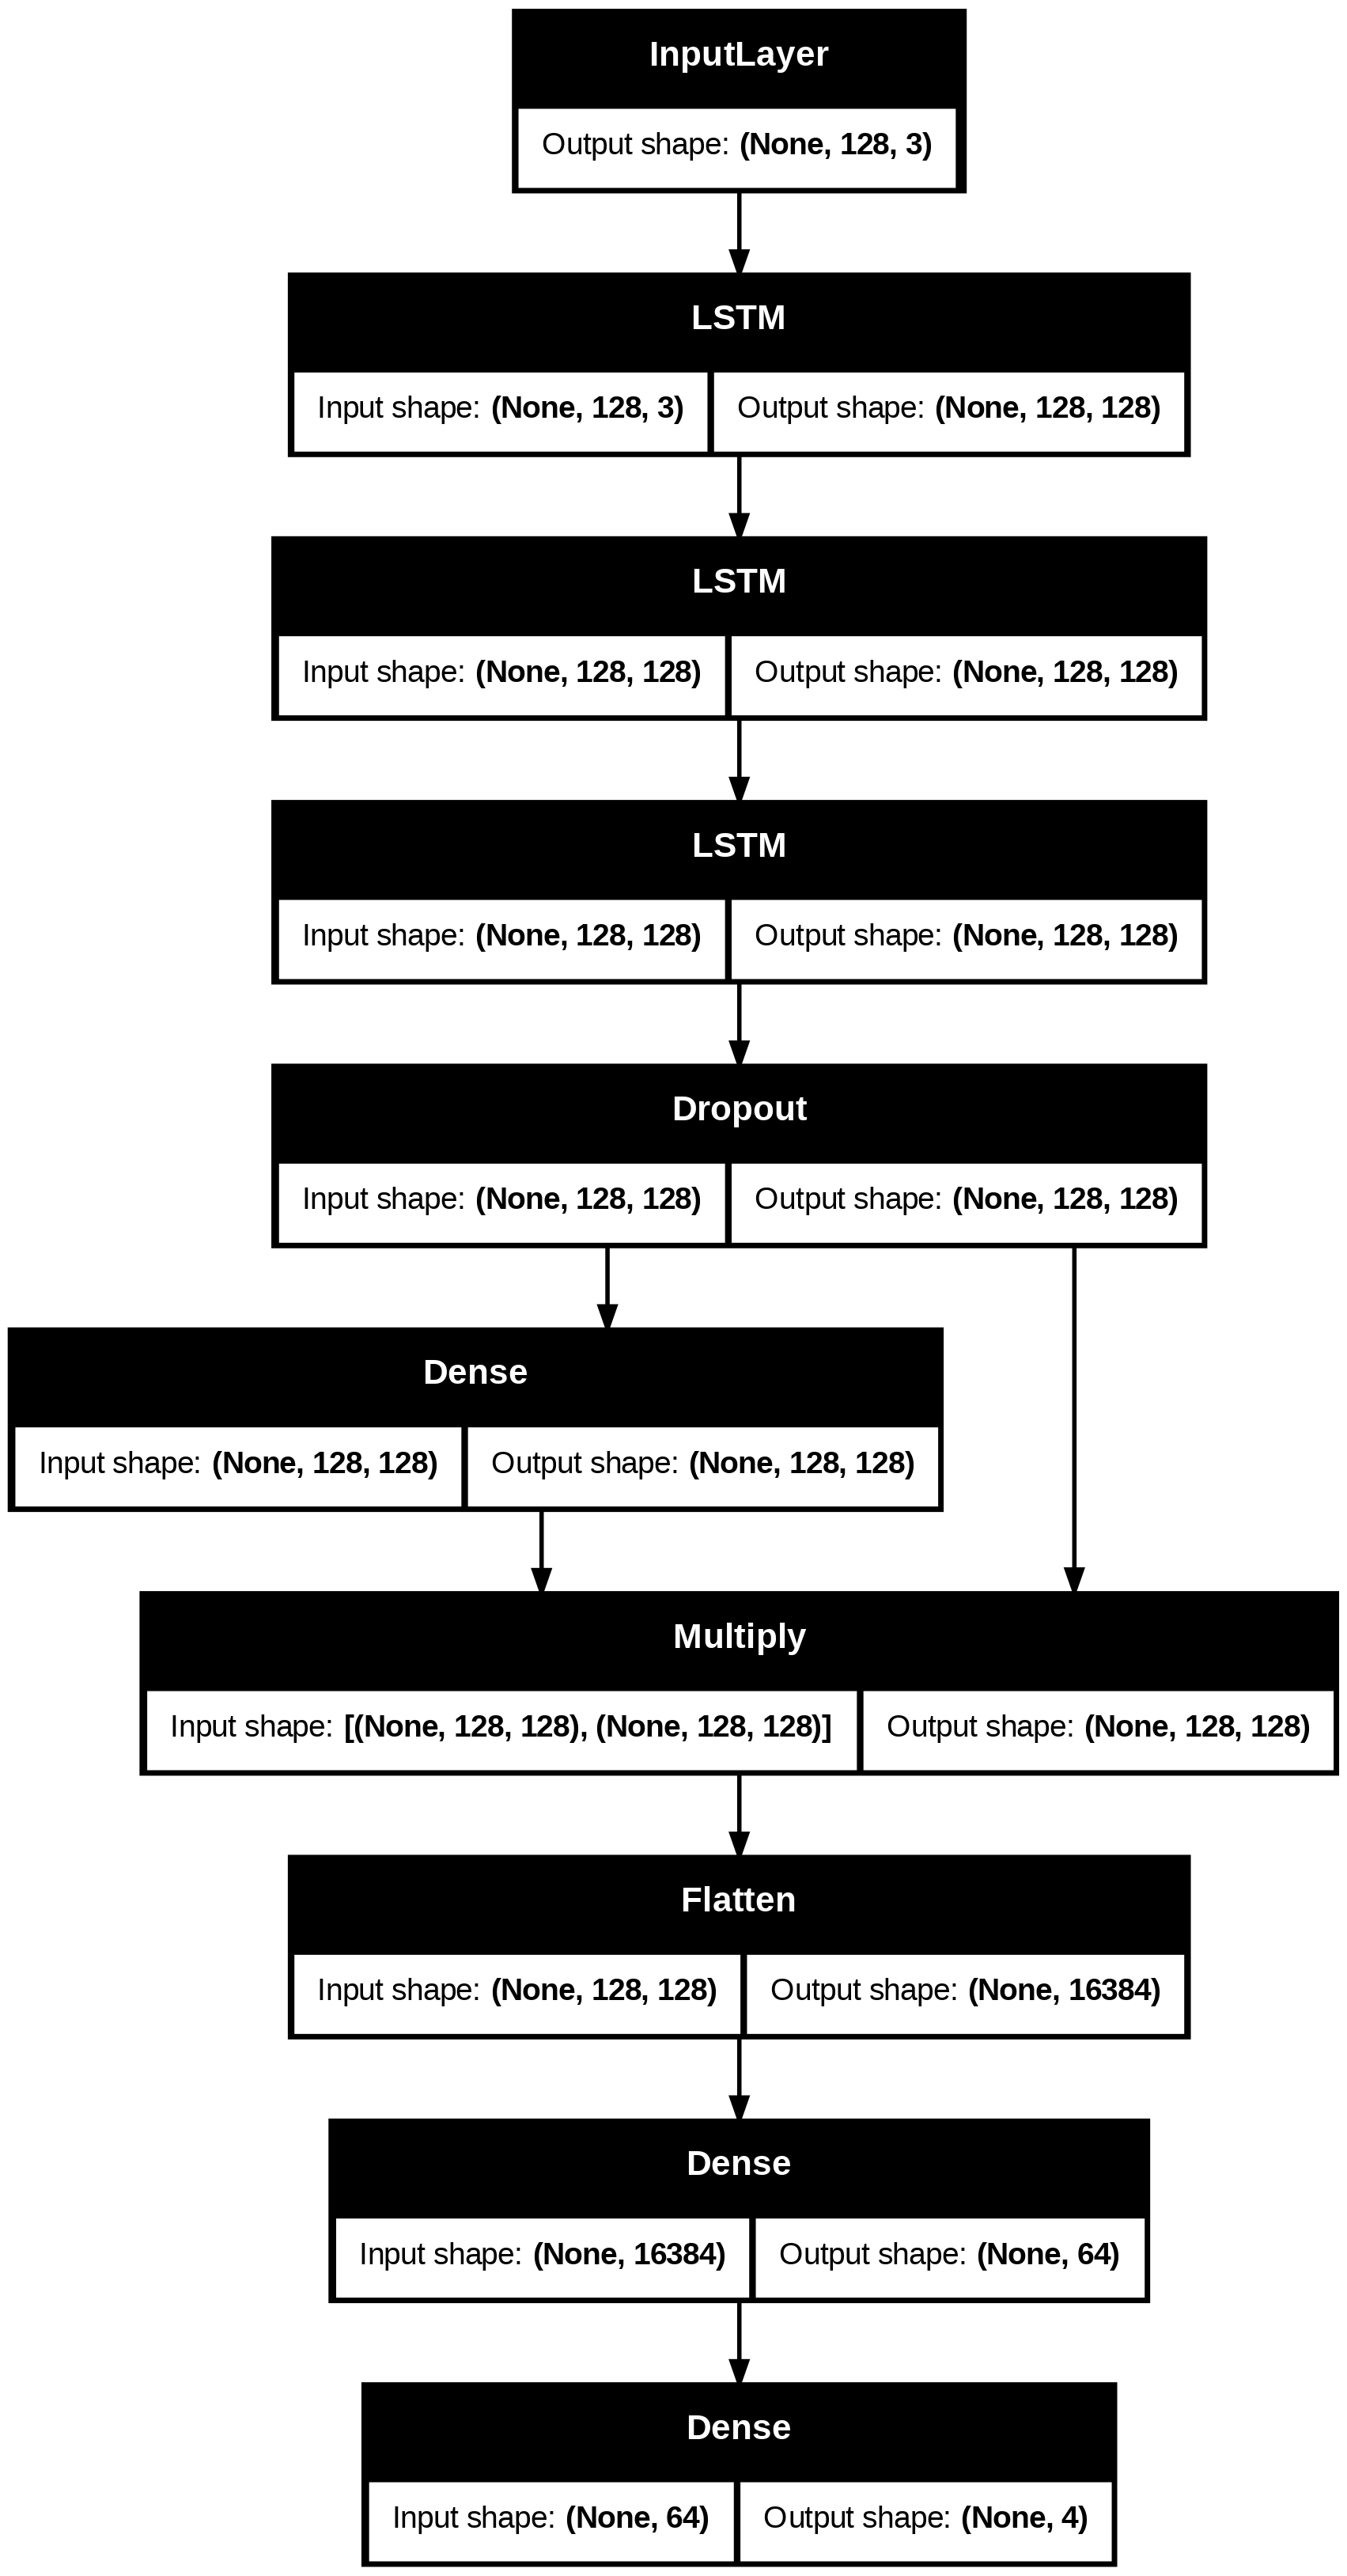

In [21]:
import tensorflow as tf
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

In [22]:
import math
import time
#from keras.callbacks import EarlyStopping
#early_stopping = EarlyStopping()

start = time.time()
model_history=model.fit(X_train, y_train_one_hot, epochs=100, batch_size=32, validation_data=(X_val, y_val_one_hot))

end = time.time()
print(f"{end - start:.5f} sec")

Epoch 1/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.4717 - loss: 1.1330 - val_accuracy: 0.5868 - val_loss: 0.8278
Epoch 2/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.6412 - loss: 0.7788 - val_accuracy: 0.7828 - val_loss: 0.5628
Epoch 3/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.8425 - loss: 0.4360 - val_accuracy: 0.9191 - val_loss: 0.2530
Epoch 4/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.8964 - loss: 0.2885 - val_accuracy: 0.9222 - val_loss: 0.2255
Epoch 5/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9280 - loss: 0.2031 - val_accuracy: 0.9396 - val_loss: 0.1876
Epoch 6/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9460 - loss: 0.1562 - val_accuracy: 0.9596 - val_loss: 0.1370
Epoch 7/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.9572 - loss: 0.1156 - val_accuracy: 0.9577 - val_loss: 0.1243
Epoch 8/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9687 - loss: 0.1014 -

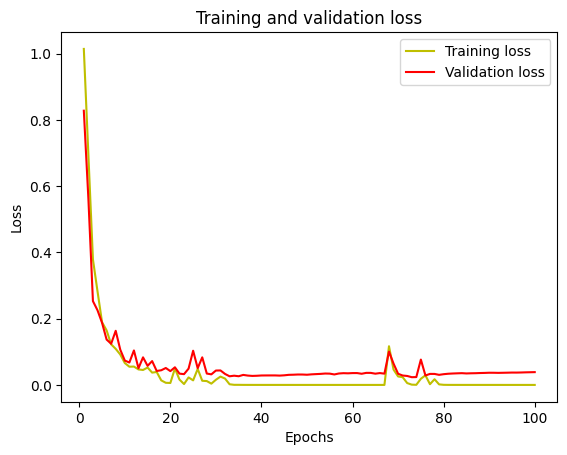

In [23]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

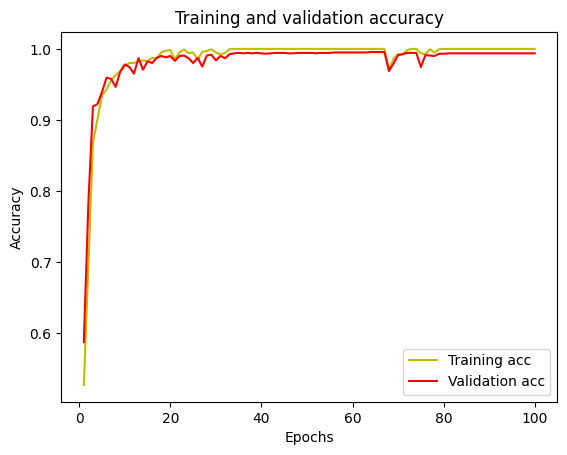

In [24]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Classification Report:
              precision    recall  f1-score   support

     Walking       0.99      1.00      0.99       502
     Jogging       1.00      1.00      1.00       502
    Upstairs       1.00      0.98      0.99       502
  Downstairs       1.00      1.00      1.00       502

    accuracy                           0.99      2008
   macro avg       0.99      0.99      0.99      2008
weighted avg       0.99      0.99      0.99      2008

Test Accuracy: 0.99


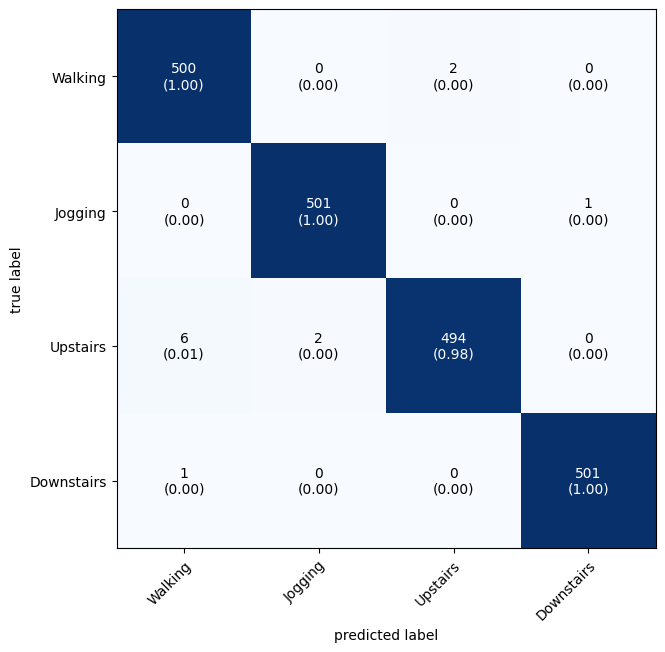

In [25]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import numpy as np

# 예측 수행
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)  # 가장 확률이 높은 클래스를 선택

# 테스트 라벨 (One-Hot Encoding → 정수형 라벨 변환)
y_test = np.argmax(y_test_one_hot, axis=-1)  # 테스트 레이블 변환

# 라벨 정의
LABELS = ['Walking', 'Jogging', 'Upstairs', 'Downstairs']

# 혼동 행렬 생성
cm = confusion_matrix(y_test, y_pred)

# 혼동 행렬 시각화
plot_confusion_matrix(conf_mat=cm, class_names=LABELS, show_normed=True, figsize=(7,7))

# 성능 보고서 출력
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=LABELS))

# 정확도 출력
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.2f}")